In [1]:
import distutils.util
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math

# assuming running from raycasting-simulation/Automator
sys.path.append("../PycastWorld")

from math import acos, asin, atan, cos, sin, tan, pi
from math import floor
from math import radians
from pycaster import PycastWorld, Turn, Walk
from numpy.random import default_rng

rng = default_rng()

# NOISE CONTROL
# the standard deviation of the Gaussian that random angles are drawn from
rand_angle_scale = pi / 36  # 5 degree s.d.

# the minimum of the uniform distribution that random distances (to move) are drawn from
rand_step_scale = 0.4

enws = {"Dir.EAST": 0, "Dir.NORTH": 90, "Dir.WEST": 180, "Dir.SOUTH": 270}


def in_targ_cell(base_dir, c_targ_x, c_targ_y, x, y):
    if base_dir == 0 or base_dir == 180:
        if abs(c_targ_x - x) < 0.4:
            return True
    else:
        if abs(c_targ_y - y) < 0.4:
            return True
    return False


class Driver:
    def __init__(
        self, c_targ_x, c_targ_y, base_dir, targ_dir, world, img_dir=None, show_freq=0, abs_base_dir=0
        
    ):
        self.c_targ_x = c_targ_x
        self.c_targ_y = c_targ_y
        self.base_dir = base_dir
        self.targ_dir = targ_dir

        self.prev_targ_angle = 0

        self.world = world
        self.curr_x = self.world.x()
        self.curr_y = self.world.y()

        self.direction = 0
        self.update_direction()

        self.dist = math.inf
        self.update_dist()

        self.angle = 0
        self.step = math.inf

        self.all_angles = np.array([])
        self.all_base_angles = np.array([])
        
        self.abs_base_dir = abs_base_dir
        
        self.left_throttle = 0
        self.right_throttle = 0

        self.img_dir = img_dir
        if self.img_dir != None:
            stack_conds = []
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "left")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "right")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "straight")))

            # if subdirectories exist, then stacking method not used
            if all(stack_conds):
                self.img_num_l = len(os.listdir(os.path.join(img_dir, "left")))
                self.img_num_r = len(os.listdir(os.path.join(img_dir, "right")))
                self.img_num_s = len(os.listdir(os.path.join(img_dir, "straight")))
                self.stack_dir = False
            else:
                self.img_num = len(os.listdir(img_dir))
                self.stack_dir = True

        self.show_freq = show_freq

    def update_dist(self):
        self.dist = math.sqrt(
            (self.c_targ_x - self.world.x()) ** 2
            + (self.c_targ_y - self.world.y()) ** 2
        )

    def update_direction(self):
        if not -1 <= self.world.get_dir_x() <= 1:
            dir_x = round(self.world.get_dir_x())
        else:
            dir_x = self.world.get_dir_x()

        if not -1 <= self.world.get_dir_y() <= 1:
            dir_y = round(self.world.get_dir_y())
        else:
            dir_y = self.world.get_dir_y()

        if dir_x > 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x <= 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x < 0 and dir_y < 0:
            dir = pi - asin(dir_y)
        elif dir_x >= 0 and dir_y < 0:
            dir = asin(dir_y)

        self.direction = dir % (2 * pi)

    # adjust for smoother path
    def modified_targ(self, delta):
        if self.base_dir == 0 or self.base_dir == 180:
            if self.targ_dir == 90:
                return self.c_targ_x, self.c_targ_y + delta
            elif self.targ_dir == 270:
                return self.c_targ_x, self.c_targ_y - delta
        elif self.base_dir == 90 or self.base_dir == 270:
            if self.targ_dir == 0:
                return self.c_targ_x + delta, self.c_targ_y
            elif self.targ_dir == 180:
                return self.c_targ_x - delta, self.c_targ_y
        return self.c_targ_x, self.c_targ_y

    def get_angle(self):
        mod_x, mod_y = self.modified_targ(0.15)
        if self.curr_x <= mod_x and self.curr_y <= mod_y:
            if mod_x == self.curr_x:
                theta = pi / 2
            else:
                theta = (atan((mod_y - self.curr_y) / (mod_x - self.curr_x))) % (2 * pi)

        # case where target pos is up and to the left
        elif self.curr_x > mod_x and self.curr_y <= mod_y:
            if mod_y == self.curr_y:
                theta = pi
            else:
                theta = (atan((self.curr_x - mod_x) / (mod_y - self.curr_y))) % (2 * pi) + pi / 2

        # case where target pos is down and to the left
        elif self.curr_x > mod_x and self.curr_y > mod_y:
            if mod_x == self.curr_x:
                theta = 3 * pi / 2
            else:
                theta = (atan((self.curr_y - mod_y) / (self.curr_x - mod_x))) % (2 * pi) + pi

        # case where target pos is down and to the right
        else:
            if self.curr_y == mod_y:
                theta = 0
            else:
                theta = (atan((mod_x - self.curr_x) / (self.curr_y - mod_y))) % (2 * pi) + 3 * pi / 2
        return theta

    def set_rand_angle(self):
        theta = self.get_angle()
        self.angle = rng.normal(loc=theta, scale=rand_angle_scale) % (2 * pi)

    def set_rand_step(self):
        self.step = rng.uniform(rand_step_scale, self.dist_to_wall())

    def abs_angle_diff(self, angle):
        abs_diff = abs(self.direction - angle)
        return abs_diff % (2 * pi)

    def turn_right(self, angle):
        if self.direction > angle:
            if self.direction - angle > pi:
                return False
            else:
                return True
        else:
            if angle - self.direction > pi:
                return True
            else:
                return False

    def turn_to_angle(self):
        self.world.walk(Walk.Stop)
        i = 0
        prev_turn = None
        turn_angle = 0.0
        angle_deg = self.angle * (180/pi)
        num_turns = 1

        while self.abs_angle_diff(self.angle) > 0.1:
            if self.turn_right(self.angle):
                if prev_turn == "left":
                    print("no left to right allowed")
                    break                
                
                agent_dir = turn_angle  
                angle_label = agent_dir
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "right",
                                f"{self.img_num_r:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_r += 1

                self.world.turn(Turn.Right)
                turn_angle += 2.5  
                self.world.update()

                prev_turn = "right"

            else:
                if prev_turn == "right":
                    print("no right to left allowed")
                    break
                    
                agent_dir = turn_angle
                angle_label = agent_dir
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "left",
                                f"{self.img_num_l:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_l += 1

                self.world.turn(Turn.Left)
                turn_angle += 2.5
                self.world.update()

                prev_turn = "left"

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.update_direction()
        self.world.turn(Turn.Stop)

    @staticmethod
    def solve_triangle(theta, a):
        b = a * tan(theta)
        c = a / cos(theta)
        return b, c

    def dist_to_wall(self):
        if self.targ_dir == 0:
            if (3 * pi / 2) <= self.direction <= (2 * pi):
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = self.direction - (3 * pi / 2)
            else:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction
        elif self.targ_dir == 90:
            if 0 <= self.direction <= (pi / 2):
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = self.direction
            else:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = pi - self.direction
        elif self.targ_dir == 180:
            if (pi / 2) <= self.direction <= pi:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction - (pi / 2)
            else:
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = (3 * pi / 2) - self.direction
        elif self.targ_dir == 270:
            if pi <= self.direction <= 3 * pi / 2:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = self.direction - pi
            else:
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = (2 * pi) - self.direction

        b, c = self.solve_triangle(theta, a)

        if b < self.dist:
            return c
        else:
            return b

    def move_to_step(self):
        self.world.turn(Turn.Stop)
        i = 0
        while (
            not in_targ_cell(
                self.base_dir, self.c_targ_x, self.c_targ_y, self.curr_x, self.curr_y
            )
            and self.step > 0.1
        ):
            angle_label = 0
            self.all_angles = np.append(self.all_angles, angle_label)
            if self.img_dir != None:
                if self.stack_dir:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                        )
                    )
                    self.img_num += 1
                else:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir,
                            "straight",
                            f"{self.img_num_s:05}_{angle_label}.png",
                        )
                    )
                    self.img_num_s += 1

            self.world.walk(Walk.Forward)
            self.world.update()

            self.curr_x = self.world.x()
            self.curr_y = self.world.y()

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.step -= self.world.walk_speed()
            self.update_dist()

        self.world.walk(Walk.Stop)


class Navigator:
    def __init__(self, maze, img_dir=None):
        self.world = PycastWorld(320, 240, maze)
        self.img_dir = img_dir
        self.abs_base_dir = 0
        self.abd_targ_dir = 0

        # getting directions
        with open(maze, "r") as in_file:
            png_count = int(in_file.readline())
            for _ in range(png_count):
                in_file.readline()

            _, dim_y = in_file.readline().split()
            for _ in range(int(dim_y)):
                in_file.readline()

            self.directions = in_file.readlines()

        self.num_directions = len(self.directions)

        self.angles = np.array([])
        self.base_angles = np.array([])
        self.dirs = []

    def navigate(self, index, show_dir=False, show_freq=0):
        _, _, s_base_dir = self.directions[index].split()
        targ_x, targ_y, s_targ_dir = self.directions[index + 1].split()
        targ_x, targ_y = int(targ_x), int(targ_y)
        

        # convert from string
        base_dir = enws[s_base_dir]
        targ_dir = enws[s_targ_dir]        
        
        if base_dir != targ_dir :
            self.abs_base_dir = base_dir
            self.abs_targ_dir = targ_dir
        if self.abs_base_dir == 0:
            self.abs_base_dir = 360
            
        _, _, s_prev_dir = None, None, None
        prev_dir = None
        if index >= 1:            
            s_prev_dir = s_targ_dir
            prev_dir = enws[s_prev_dir]
            if base_dir != prev_dir:
                self.abs_base_dir = prev_dir
        # we know prev direction; calculate the angle direction we need and 
        # keep that angle direction until the current direction changes again. 
        # e.g. West -> North means turn right until North -> East so on and so forth
        if show_dir:
            print(f"Directions: {targ_x}, {targ_y}, {s_targ_dir}, basedir: {s_base_dir}, \
            abs base dir: {self.abs_base_dir}\
            prev dir: {s_prev_dir}")

        # center of target cell
        c_targ_x = targ_x + 0.5
        c_targ_y = targ_y + 0.5

        driver = Driver(
            c_targ_x, c_targ_y, base_dir, targ_dir, self.world, self.img_dir, show_freq, self.abs_base_dir
        )

        while not in_targ_cell(
            base_dir, c_targ_x, c_targ_y, driver.curr_x, driver.curr_y
        ):
            driver.set_rand_angle()
            driver.turn_to_angle()
            driver.set_rand_step()
            driver.move_to_step()
        
#         print("made it to targ cell..moving to next")
        self.angles = np.append(self.angles, driver.all_angles)
        return prev_dir

    def plot_angles(self):
        plt.plot(self.angles)
        plt.show()

    def plot_directions(self):
        plt.plot(self.dirs)
        plt.show()

    def plot_label_dir(self):
        plt.plot(self.directions)
        plt.show()

In [160]:
mazes = ["../Mazes/15_mazes_test_07-07-2021_16-07/maze_1.txt",
         "../Mazes/15_mazes_test_07-07-2021_16-07/maze_2.txt", 
         "../Mazes/15_mazes_test_07-07-2021_16-07/maze_3.txt",
         "../Mazes/15_mazes_test_07-07-2021_16-07/maze_4.txt"]
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_5.txt"]
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_6.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_7.txt", 
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_8.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_9.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_10.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_11.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_12.txt", 
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_13.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_14.txt",
#          "../Mazes/15_mazes_test_07-07-2021_16-07/maze_15.txt"]

for m in mazes:
    maze = m
    print(maze)
    show_freq = 0  # frequency to show frames
    img_dir = "/raid/Images/test" # directory to save images to
    show_dir = True

    navigator = Navigator(maze, img_dir)

    j = 0
    while j < navigator.num_directions - 1:
        navigator.navigate(j, show_dir=show_dir, show_freq=show_freq)
        j += 1

../Mazes/15_mazes_test_07-07-2021_16-07/maze_1.txt
Directions: 3, 1, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: None
Directions: 5, 1, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 7, 1, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 7, 3, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 9, 3, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 11, 3, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 13, 3, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 13, 5, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 15, 5, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev 

Directions: 3, 19, Dir.SOUTH, basedir: Dir.SOUTH,             abs base dir: 270            prev dir: Dir.SOUTH
Directions: 3, 17, Dir.SOUTH, basedir: Dir.SOUTH,             abs base dir: 270            prev dir: Dir.SOUTH
Directions: 3, 15, Dir.EAST, basedir: Dir.SOUTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 5, 15, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 7, 15, Dir.SOUTH, basedir: Dir.EAST,             abs base dir: 270            prev dir: Dir.SOUTH
Directions: 7, 13, Dir.SOUTH, basedir: Dir.SOUTH,             abs base dir: 270            prev dir: Dir.SOUTH
Directions: 7, 11, Dir.EAST, basedir: Dir.SOUTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 9, 11, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 9, 13, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 11, 13,

Directions: 17, 7, Dir.SOUTH, basedir: Dir.EAST,             abs base dir: 270            prev dir: Dir.SOUTH
Directions: 17, 5, Dir.EAST, basedir: Dir.SOUTH,             abs base dir: 0            prev dir: Dir.EAST
Directions: 19, 5, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 21, 5, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
Directions: 23, 5, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 23, 7, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 23, 9, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            prev dir: Dir.WEST
Directions: 21, 9, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH
Directions: 21, 11, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            prev dir: Dir.WEST
Directions: 19, 11, 

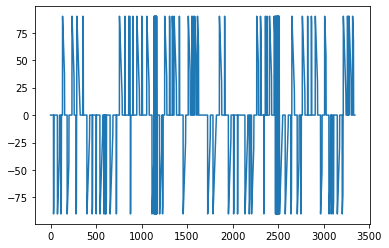

In [162]:
plt.plot(navigator.angles)
plt.show()

In [2]:
from fastai.vision.all import *
from fastai import *
import datetime;
from fastai.vision.widgets import *
import torch 
from math import pi

In [3]:
path = Path('/raid/Images/test')

num_img = !ls -l '/raid/Images/test' | wc -l

int(num_img[0])

10279

In [163]:
get_image_files(path)

(#10278) [Path('/raid/Images/test/08476_0.png'),Path('/raid/Images/test/04664_0.png'),Path('/raid/Images/test/01930_12.5.png'),Path('/raid/Images/test/06766_67.5.png'),Path('/raid/Images/test/03039_0.png'),Path('/raid/Images/test/02744_0.png'),Path('/raid/Images/test/01406_65.0.png'),Path('/raid/Images/test/04843_40.0.png'),Path('/raid/Images/test/00858_0.png'),Path('/raid/Images/test/04751_0.png')...]

In [51]:
r_path = Path('/raid/Images/test/right')
l_path = Path('/raid/Images/test/left')

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.set_device(1)

In [6]:
torch.cuda.current_device()

1

In [136]:
sample_lab = "02905_0_straight.png"
sample_lab.split('_')[2][:-4]
tensor((1,12), (23,155))

tensor([[  1,  12],
        [ 23, 155]])

In [39]:
img_files = get_image_files(path)

In [40]:
im = PILImage.create(img_files[0])
im.shape

(240, 320)

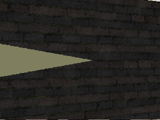

In [41]:
im.to_thumb(160)

In [7]:
def get_deg(f):
    sample_lab = f.name
    deg = float(sample_lab.split('_')[1][:-4])
    return tensor(deg).unsqueeze(0)

In [8]:
s = "04504_-72.5.png"
split_name = s.split('_')
angle = float(split_name[1][:-4])
if angle < 0:
    throttle = (0,-angle)
elif angle > 0:
    throtttle = (angle,0)
else:
    throttle = (2.5, 2.5)
throttle

(0, 72.5)

In [13]:
def get_throttles(f):
    split_name = f.name.split('_')
    angle = float(split_name[1][:-4])
    if angle < 0:
        return tensor([2.5, -2.5])#torch.stack((tensor(0.),tensor(-angle)))
    elif angle > 0:
        return tensor([-2.5, 2.5])#torch.stack((tensor(angle),tensor(0.)))
    else:
        return tensor([2.5, 2.5])#torch.stack((tensor(2.5),tensor(2.5)))

In [14]:
db_r = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    get_y=get_throttles,
    splitter=RandomSplitter(valid_pct=0.2, seed=47),
)

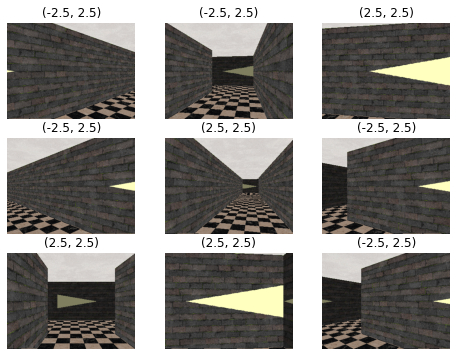

In [17]:
dls_r = db_r.dataloaders(path)
dls_r.show_batch(max_n=9, figsize=(8,6))

In [26]:
xb,yb = dls_r.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 2]))

In [94]:
torch.where(torch.abs((y[:, 1] - y[:, 0]) - (yhat[:, 1] - yhat[:, 0])) < 0.1, 1., 0.).mean()

tensor(1.)

In [17]:
yb[0]

TensorPoint([[0., 0.]], device='cuda:1')

In [18]:
def angle_loss(preds, targs):
    pred_angle_list = [e[0] for e in preds]
    pred_turn_list = [e[1] for e in preds]
    
    targs_angle_list = [e[0] for e in targs]
    targs_turn_list = [e[1] for e in targs]
    
    angle_preds = torch.stack(pred_angle_list)
    turn_preds = torch.stack(pred_turn_list)
    
    angle_targs = torch.stack(targs_angle_list)
    turn_targs = torch.stack(targs_turn_list)
    return ((angle_preds - angle_targs)**2 + ((turn_preds - turn_targs)**2)).mean()

In [19]:
def steering_loss(preds, targs):
    angle_true = targs[:, 1] - targs[:, 0]
    angle_pred = preds[:, 1] - preds[:, 0]
    weight = torch.abs(angle_true + 0.05)
    return (
        torch.square(weight)
        * (torch.nn.functional.mse_loss(angle_true, angle_pred, reduction="none").T)
    ).mean() + torch.nn.functional.mse_loss(targs, preds)

In [20]:
num_train_examples = 10
num_output_neurons = 2
yhat = torch.vstack(
    [
        torch.linspace(1, 10, num_train_examples),
        torch.linspace(1, 10, num_train_examples),
    ]
).T
y = torch.ones((num_train_examples, num_output_neurons))
steering_loss(yhat, y)

tensor(28.5000)

In [130]:
y,yhat

(tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[ 1.,  1.],
         [ 2.,  2.],
         [ 3.,  3.],
         [ 4.,  4.],
         [ 5.,  5.],
         [ 6.,  6.],
         [ 7.,  7.],
         [ 8.,  8.],
         [ 9.,  9.],
         [10., 10.]]))

In [25]:
yhat.shape

torch.Size([10, 2])

In [26]:
torch.nn.functional.mse_loss(y, yhat, reduction="none")

tensor([[ 0.,  0.],
        [ 1.,  1.],
        [ 4.,  4.],
        [ 9.,  9.],
        [16., 16.],
        [25., 25.],
        [36., 36.],
        [49., 49.],
        [64., 64.],
        [81., 81.]])

In [27]:
torch.nn.functional.mse_loss(y, yhat)

tensor(28.5000)

In [30]:
angle_true = y[:, 1] - y[:, 0]
angle_pred = yhat[:, 1] - yhat[:, 0]

In [31]:
(torch.square(torch.abs((y[:,1] - yhat[:,0]) + 0.05)) * 
 torch.nn.functional.mse_loss(angle_true, angle_pred, reduction='none').T).mean() + torch.nn.functional.mse_loss(y, yhat)

tensor(28.5000)

In [193]:
torch.nn.functional.mse_loss(y, yhat, reduction='none').T

tensor([[ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.],
        [ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.]])

In [21]:
def angle_metric(preds, targs):
    angle_true = targs[:, 1] - targs[:, 0]
    angle_pred = preds[:, 1] - preds[:, 0]
    return torch.where(torch.abs(angle_true - angle_pred) < 0.1, 1., 0.).mean()

In [22]:
def direction_metric(preds, targs):
    angle_true = targs[:, 1] - targs[:, 0]
    angle_pred = preds[:, 1] - preds[:, 0]
    return torch.where(
        torch.logical_or(
            torch.sign(angle_pred) == torch.sign(angle_true),
            torch.abs(angle_pred) < 0.1,
        ),
        1.0,
        0.0,
    ).mean()

In [24]:
learn = cnn_learner(
    dls_r,
    resnet18,
    y_range=(-100, 100),
    metrics=[mse, angle_metric, direction_metric],
)
learn.fine_tune(
    20,
    cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor="valid_loss", patience=5)],
)

Better model found at epoch 0 with valid_loss value: 678.286865234375.


Better model found at epoch 0 with valid_loss value: 144.0153350830078.
Better model found at epoch 1 with valid_loss value: 58.36905288696289.
Better model found at epoch 2 with valid_loss value: 20.84771156311035.
Better model found at epoch 3 with valid_loss value: 6.562037467956543.
Better model found at epoch 4 with valid_loss value: 3.1652112007141113.
Better model found at epoch 5 with valid_loss value: 2.9088549613952637.
Better model found at epoch 6 with valid_loss value: 2.666984796524048.
Better model found at epoch 7 with valid_loss value: 2.2416317462921143.
Better model found at epoch 9 with valid_loss value: 1.7758411169052124.
Better model found at epoch 10 with valid_loss value: 1.6896836757659912.
Better model found at epoch 11 with valid_loss value: 1.431929588317871.
Better model found at epoch 13 with valid_loss value: 1.3740642070770264.
Better model found at epoch 14 with valid_loss value: 1.1078159809112549.
Better model found at epoch 15 with valid_loss value:

In [23]:
learn2 = cnn_learner(
    dls_r,
    resnet18,
    y_range=(-100, 100),
    loss_func=steering_loss,
    metrics=[mse, angle_metric, direction_metric],
)
learn2.fine_tune(
    20,
    cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor="valid_loss", patience=5)],
)

Better model found at epoch 0 with valid_loss value: 11400.775390625.


Better model found at epoch 0 with valid_loss value: 10504.8994140625.
Better model found at epoch 1 with valid_loss value: 9804.83984375.
Better model found at epoch 2 with valid_loss value: 9472.8486328125.
Better model found at epoch 4 with valid_loss value: 8854.4365234375.
Better model found at epoch 5 with valid_loss value: 6316.25634765625.
Better model found at epoch 6 with valid_loss value: 3298.394287109375.
Better model found at epoch 7 with valid_loss value: 1417.1910400390625.


KeyboardInterrupt: 

In [117]:
learn2.loss_func

<function __main__.steering_loss(preds, targs)>

In [328]:
0-30

-30

In [63]:
learn.export('/home/CAMPUS/eoca2018/raycasting-simulation/Models/point_block_reg.pkl')

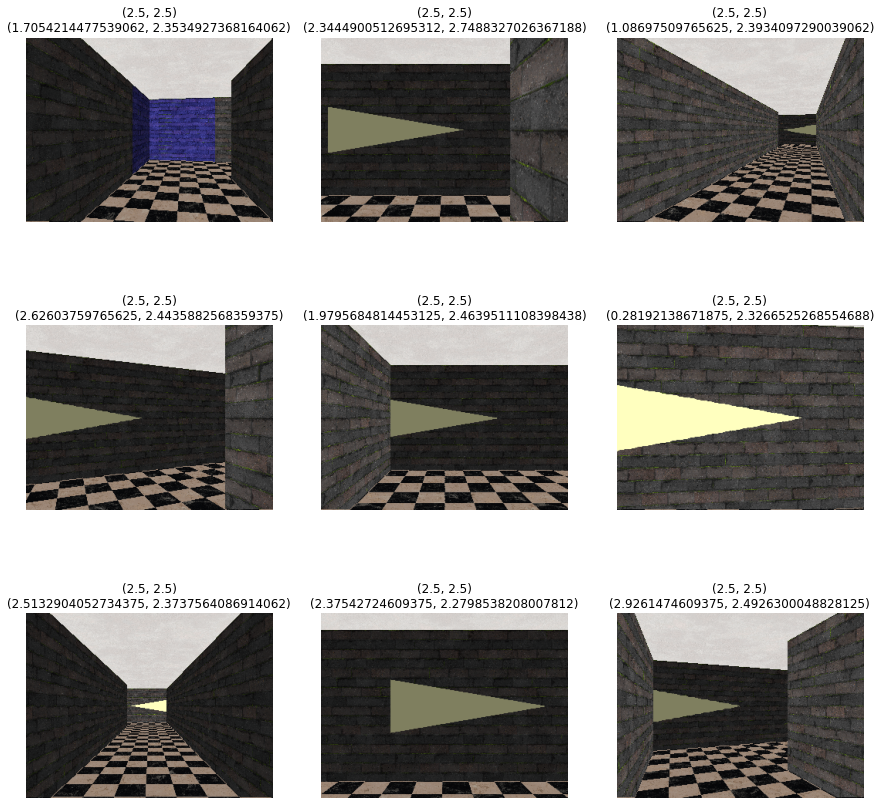

In [26]:
learn.show_results(ds_idx=1, nrows=3, figsize=(15,15))

In [62]:
learn.predict(get_image_files(path)[0])

(TensorPoint([[198.1909, 120.1501]]),
 tensor([0.2387, 0.0013]),
 tensor([0.2387, 0.0013]))

In [34]:
get_image_files(path)[0]

Path('/raid/Images/test/right/00079_35.0436.png')

# Try Predicting with the Regression Model

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
steps_per_episode = 2000

env = PycastWorldEnv("../Mazes/maze01-long.txt", 320, 240)

path = Path('/home/CAMPUS/eoca2018/raycasting-simulation/Models/steering_loss.pkl')
# Run some number of trials all starting from the
# initial location. We might eventually randomize
# the maze and the starting location.

# Grab the initial observation (not used here)
observation = env.reset()
frames = [observation.copy()]
model_inf = load_learner(path)
prev_pred = 0

plt.imshow(observation)

NameError: name 'Path' is not defined

In [300]:
print("Predicting...")
for t in range(steps_per_episode):    
    pred_angle, _, _ =  model_inf.predict(observation)
    pred_angle = math.ceil(pred_angle[0])
    print(pred_angle)
    num_movements = abs(int(pred_angle / 20))
    
    if num_movements == 0:
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
        prev_pred = pred_angle
        
        if done:
            print(f"  Found goal in {t+1} steps")
            break
        continue
    
    if (prev_pred > 0 and pred_angle < 0) or (prev_pred < 0 and pred_angle > 0):
        print("left-right mixup")
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
        prev_pred = pred_angle        
        if done:
            print(f"  Found goal in {t+1} steps")
            break        
        continue
        
    # check if we have to move opposite
#     if abs(prev_pred) > abs(pred_angle) + 5:
#         print("preventing overturn")
#         action_index = 1
#         observation, reward, done, info = env.step(action_index)
#         frames.append(observation.copy())
#         continue
             
    action_index = 1
    if pred_angle > 0 and num_movements > 0:
        for i in range(num_movements):
            action_index = 0 # turn left
            observation, reward, done, info = env.step(action_index)
            frames.append(observation.copy())
    elif pred_angle < 0 and num_movements > 0:
        for i in range(num_movements):
            action_index = 2 # turn right
            observation, reward, done, info = env.step(action_index)
            frames.append(observation.copy())

    prev_pred = pred_angle
    # Check if we reached the end goal
    if done:
        print(f"  Found goal in {t+1} steps")
        break

print(f"  Ended at position {env.world.x()}, {env.world.y()}")
env.close();

Predicting...


-8


-3


5


2


-1


6


3


1


1


2


-2


3


7


4


-2


-1


3


1


4


3


5


5


5


7


12


15


11


13


21


14


3


1


9


47


62


72


85


89


80


51


25


25


35


31


23


17


20


10


7


7


4


2


-1


8


1


-2


3


-2


-5


0


-3


-3


-5


-3


-2


0


-3


-3


7


6


-1


1


2


0


-1


2


3


-7


-4


-50


-46


-69


-70


-70


-57


-58


-41


-28


-33


-28


-22


-12


-12


-11


-15


-12


-7


-7


-8


5


3


0


-8


-8


-9


-5


0


-1


-9


-15


-11


-9


-13


2


-5


-8


-20


-9


-7


-15


-12


-11


-19


-13


-28


-32


-21


-30


-16


-11


-8


-8


-13


-19


-10


-20


-22


-13


-7


-7


3


-11


6


4


-9


-9


-8


-7


2


2


10


-2


6


7


-5


-8


-4


-5


-2


-9


0


-6


4


5


-8


-9


-7


-5


1


2


14


3


-8


-1


-6


-6


-1


0


0


-6


-1


-4


-1


-1


-3


-3


-5


-5


-3


-4


-1


-2


-7


-1


-6


-5


-3


-4


-1


-4


-2


-1


3


1


1


9


-7


-6


2


-65
left-right mixup


-86


-83


-88


-72


-72


-50


-40


-41


-19


-30


-12


-18


-18


-16


-12


-8


-14


-14


-4


-6


-8


-10


-1


-2


1


-8


-2


-4


-5


-2


-1


-2


-4


-4


-12


-10


-1


-15


40
left-right mixup


66


63


70


66


51


26


29


20


11


22


27


5


1


17


19


13


14


12


11


9


19


8


14


10


13


15


19


17


20


16


17


20


26


20


16


19


27


15


18


15


-15


0


23


2


84


90


90


86


50


68


56


40


23


13


17


5


10


7


3


1


1


1


-2


-12


-11


0


3


1


21


23


3


2


10


3


-3


3


-2


-2


3


-2


0


-2


-6


-16


-6


-19


-67


-70


-63


-61


-60


-48


-29


-25


-29


-17


-18


-17


-16


-16


-12


-12


-10


-6


-5


-9


-11


-8


-7


-12


-9


-8


-11


0


5


-3


0


-7


-8


-13


-25


-29


-22


-5


-28


-12


-59


-44


-47


-22


13


-86
left-right mixup


-89


-88


-80


-70


-61


-41


-24


-20


-23


-18


-10


-3


-6


-14


-11


-6


-8


-6


-5


-2


-6


-1


3


-1


-2


4


-8


0


-5


5


-1


-1


-16


2


-2


-12


-9


-26


-21


-21


-8


-25


-13


-19


-37


-40


-10


18


83


87


89


87


63


42


27


31


30


23


18


17


19


8


9


10


10


16


14


21


9


14


11


20


20


16


6


30


11


15


15


12


24


24


19


20


17


17


23


18


15


13


10


5


-2


12


26


35


44


76


62


86


85


74


53


36


24


34


39


33


9


16


9


8


5


11


1


5


-2


-2


-5


-10


-7


-3


0


3


1


4


3


8


-3


-7


-2


-1


1


-1


-7


1


-6


-5


0


-11


-47


-71


-68


-50


-57


-57


-50


-41


-18


-24


-23


-21


-11


-11


-12


-4


-14


-4


0


2


-5


-2


-5


-9


-1


-6


-7


-10


-11


-8


-5


-2


-6


-1


-10


-6


-5


-13


-13


-10


-17


-17


-14


-14


-5


-12


-15


-12


-10


-7


-7


-4


2


-9


0


-2


0


5


0


2


-2


0


-3


-1


2


2


1


0


-3


-16


1


-2


2


-7


-1


1


0


-17


-15


-34


-8


41
left-right mixup


83


73


69


58


55


37


41


31


25


16


25


18


16


20


14


20


15


18


18


25


24


15


13


18


18


23


21


23


17


13


19


10


15


12


5


7


10


-2


-11


-10


8


49


32


47


50


54


73


88


87


72


72


39


39


33


32


19


19


17


13


22


9


6


1


2


2


5


7


5


5


6


5


13


1


5


15


-1


11


11


-2


12


7


6


19


15


13


26


10


20


14


20


22


13


21


18


12


16


12


14


19


17


4


12


4


4


0


3


3


5


3


-1


1


-3


-1


5


2


6


4


1


0


1


1


5


11


7


5


4


3


1


-4


-5


-9


-8


3


-28
left-right mixup


-83


-73


-47


-34


-46


-28


-51


-48


-36


-35


-37


-26


-32


-27


-20


-17


-21


-14


-19


-11


-11


-11


-12


-13


-17


-5


-5


-4


-12


-7


-8


-18


-8


-4


2


-1


-9


-25


-11


-34


-23


-16


-75


-71


-73


-73


-73


-78


-77


-73


-48


-51


-55


-20


-24


-17


-9


-12


-12


-3


-6


-5


-4


0


6


4


-2


-6


-9


-10


-5


-15


-6


-12


-1


-2


-15


-4


0


-4


2


-1


-8


-24


-11


-34


2


-16


-24


-8


49
left-right mixup


89


90


89


82


59


36


43


28


24


12


15


8


7


4


1


3


4


14


8


14


13


22


16


15


33


9


19


7


13


18


11


16


17


14


24


31


21


21


19


17


14


17


25


15


14


7


14


22


24


9


7


12


16


11


-3


14


5


10


1


13


8


13


10


5


5


7


5


3


11


1


3


5


8


2


12


11


6


6


1


-2


-4


-4


-5


4


-2


-14


-7


20
left-right mixup


47


71


78


86


76


78


57


33


23


21


36


24


15


13


18


10


5


6


1


5


2


5


4


2


-6


-7


-1


-4


3


3


3


3


6


9


4


5


1


-4


7


9


6


6


13


6


-33
left-right mixup


-76


-57


-62


-56


-46


-35


-52


-28


-31


-25


-28


-26


-13


-21


-19


-16


-13


-9


-8


-2


-2


-12


-13


-6


-8


-11


-2


-2


-5


-7


-9


-9


-14


-14


-7


-3


-1


-5


2
  Ended at position 15.647419608145269, 13.063319485500983


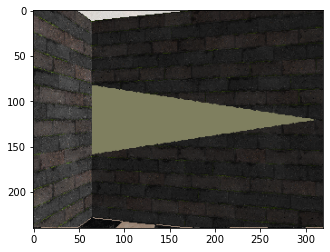

In [301]:
fig, ax = plt.subplots()
ln = plt.imshow(frames[0])
def init():
    ln.set_data(frames[0])
    return [ln]

def update(frame):
    ln.set_array(frame)
    return [ln] 

ani = FuncAnimation(fig, update, frames, init_func=init, interval=60)
smaller_frames = frames[::3] 
ani = FuncAnimation(fig, update, smaller_frames, init_func=init, interval=60)
HTML(ani.to_html5_video())

# Loss vs Non-Loss Comparison

In [53]:
path = Path('/home/CAMPUS/eoca2018/raycasting-simulation/Models/proxy_regression_model_loss.pkl')
path2 = Path('/home/CAMPUS/eoca2018/raycasting-simulation/Models/proxy_regression_model_norm.pkl')

In [59]:
model_inf_loss = load_learner(path)
model_inf = load_learner(path2)

ValueError: This DataLoader does not contain any batches